In [1]:
#Import needed libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from joblib import Parallel, delayed


In [2]:
ddos_data = pd.read_csv("ddos_dataset.csv", sep=",")
ddos_data.rename(columns=lambda x: x.strip(), inplace=True)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].apply(lambda x: str(x) if x == 0 else x)
ddos_data['SimillarHTTP'] = ddos_data['SimillarHTTP'].str.strip().fillna(0, inplace=True)


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (85) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#standardize
# Get X and y
ddos_data.drop(columns=["Unnamed: 0","Destination IP","Source IP","Timestamp","SimillarHTTP"],axis=1,inplace=True)
ddos_data_original = ddos_data.copy()
ddos_data=ddos_data.set_index('Flow ID')
print(ddos_data)
X = ddos_data.drop(columns=['label']).to_numpy()
y = ddos_data[['label']].values

# Scale Data
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

#PCA
pca = PCA(n_components=9, random_state = 15)
X_s = pca.fit_transform(X_s)


                                        Source Port  Destination Port  \
Flow ID                                                                 
172.16.0.5-192.168.50.1-634-60495-17            634             60495   
172.16.0.5-192.168.50.1-60495-634-17            634             60495   
172.16.0.5-192.168.50.1-634-46391-17            634             46391   
172.16.0.5-192.168.50.1-634-11894-17            634             11894   
172.16.0.5-192.168.50.1-634-27878-17            634             27878   
...                                             ...               ...   
172.16.0.5-192.168.50.1-38625-63051-17        38625             63051   
172.16.0.5-192.168.50.1-58632-18963-17        58632             18963   
172.16.0.5-192.168.50.1-46104-64704-17        46104             64704   
172.16.0.5-192.168.50.1-60686-10440-17        60686             10440   
172.16.0.5-192.168.50.1-45602-1387-17         45602              1387   

                                        Protocol  

Best initial k:  12  with corresponding silhouette:  0.6598490333809509
Best refined k:  10  with corresponding silhouette:  0.6593957744504438
           Label  Unique_Clusters_Count
0         benign                      9
1       ddos_dns                      7
2      ddos_ldap                      5
3     ddos_mssql                      4
4   ddos_netbios                      3
5       ddos_ntp                      6
6      ddos_snmp                      1
7      ddos_ssdp                      5
8       ddos_syn                      4
9      ddos_tftp                      5
10      ddos_udp                      3
11  ddos_udp_lag                      1


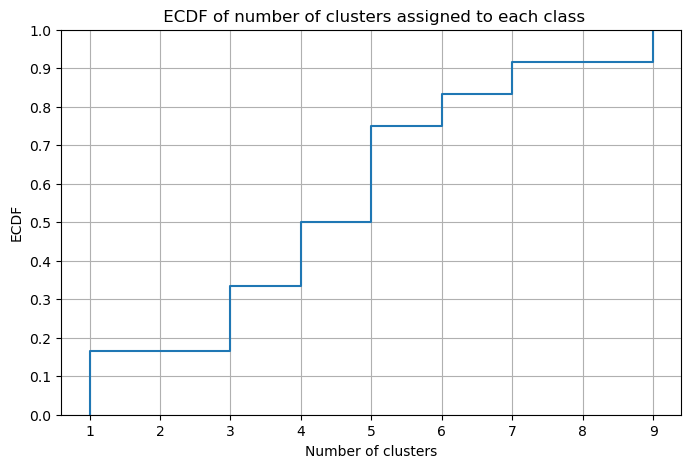

Cluster 1 is not pure
Cluster 3 is not pure
Cluster 4 is not pure
Cluster 5 is not pure
Cluster 6 is pure
Cluster 7 is pure
Cluster 9 is pure


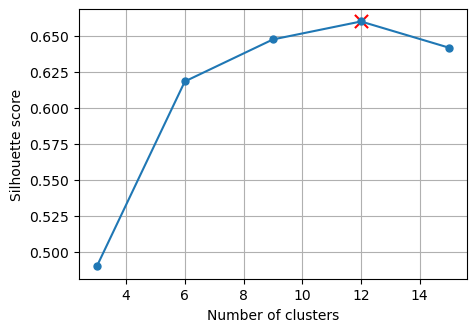

CPU times: user 1.14 s, sys: 1.48 s, total: 2.62 s
Wall time: 2min 5s


In [4]:
%%time

#K-means

# Function to perform KMeans clustering and store metrics
def perform_kmeans_clustering(n_clusters, X_s, y):
    kmeans = KMeans(n_clusters=n_clusters)
    cl_labels = kmeans.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    inertia = kmeans.inertia_

    return n_clusters, silhouette, ri, ari, inertia, cl_labels

# Step 1: Initial broader search
n_cluster_list = []
shs_list = []
ri_list = []
ari_list = []
inertia_list = []

# Define a range of n_clusters for the initial broader search
initial_range = range(3, 16, 3)

# Use Parallel and delayed to parallelize the loop
results = Parallel(n_jobs=-1)(delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in initial_range)

# Extract the results into separate lists
n_cluster_list, shs_list, ri_list, ari_list, inertia_list, tmp = zip(*results)

# Get n_clusters leading to the highest silhouette
best_sh = np.max(shs_list)
best_n = n_cluster_list[np.argmax(shs_list)]
print("Best initial k: ", best_n, " with corresponding silhouette: ", best_sh)

# Step 2: Refine search around the best k found
refined_n_cluster_list = []
refined_shs_list = []
refined_ri_list = []
refined_ari_list = []
refined_inertia_list = []

# Define the refined range around the best k
refined_range = range(max(3, best_n - 2), min(16, best_n + 3))
    
# Use Parallel and delayed to parallelize the loop for the refined search
results_refined = Parallel(n_jobs=-1)(delayed(perform_kmeans_clustering)(n_clusters, X_s, y) for n_clusters in refined_range)

# Extract the results into separate lists
refined_n_cluster_list, refined_shs_list, refined_ri_list, refined_ari_list, refined_inertia_list, refined_cl_labels_list = zip(*results_refined)

# Get the best refined k
best_refined_sh = np.max(refined_shs_list)
best_refined_n = refined_n_cluster_list[np.argmax(refined_shs_list)]
print("Best refined k: ", best_refined_n, " with corresponding silhouette: ", best_refined_sh)

# Find the index of best_refined_n in refined_n_cluster_list
best_refined_index = refined_n_cluster_list.index(best_refined_n)

# Use this index to get the corresponding cluster labels
best_refined_cl_labels = refined_cl_labels_list[best_refined_index]

# best_refined_cl_labels now contains the cluster labels for the best refined clustering
ddos_tmp = ddos_data_original.copy()
ddos_tmp['assigned_cluster'] = best_refined_cl_labels







# Group by 'label' and count unique clusters for each label
unique_clusters_per_label = ddos_tmp.groupby('label')['assigned_cluster'].nunique()

# Create a new DataFrame from the result
label_cluster_count_df = unique_clusters_per_label.reset_index()
label_cluster_count_df.columns = ['Label', 'Unique_Clusters_Count']

# 'label_cluster_count_df' now contains each label with the count of unique clusters associated with it
print(label_cluster_count_df)
# sezione 4
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=label_cluster_count_df, x='Unique_Clusters_Count')
plt.title(' ECDF of number of clusters assigned to each class')
plt.xlabel('Number of clusters')
plt.ylabel('ECDF')
plt.yticks(np.arange(0, 1.1, 0.1))  # This sets y-ticks at intervals of 0.1
plt.grid(True)
plt.show()


# Group by cluster label
grouped_by_cluster = label_cluster_count_df.groupby('Unique_Clusters_Count')

# Initialize a dictionary to hold the purity status of each cluster
cluster_purity = {}

# Check each cluster
for cluster_label, group in grouped_by_cluster:
    unique_labels = group['Label'].unique()
    cluster_purity[cluster_label] = len(unique_labels) == 1

# Print the purity status of each cluster
for cluster_label, is_pure in cluster_purity.items():
    print(f"Cluster {cluster_label} is {'pure' if is_pure else 'not pure'}")




# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

best k:  7  with corresponding silhouette:  0.6005188797984231


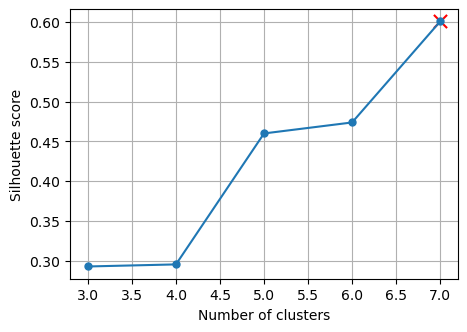

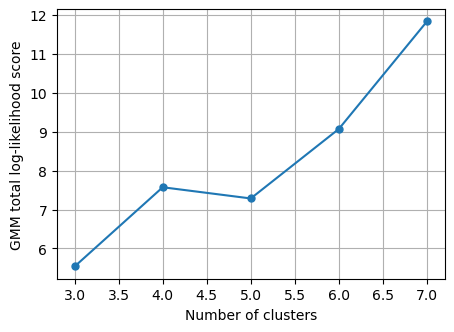

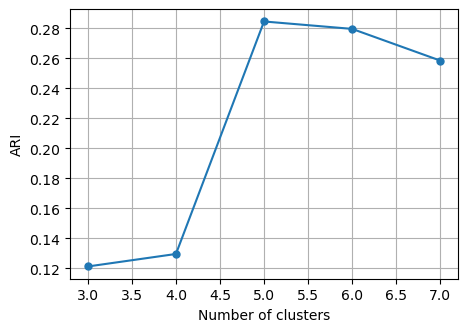

CPU times: user 683 ms, sys: 386 ms, total: 1.07 s
Wall time: 1min 1s


In [5]:

%%time
#GaussianMixture
#In this case use as hyper-parameter init_params = kmeans

#We computer the different scores for each iteration

n_cluster_list=[]
shs_list = []
ri_list = []
ari_list = []
log_l_list=[]

#we execute in parallel
def cluster_and_evaluate(n_clusters, X_s, y):
    gmm = GaussianMixture(n_components=n_clusters, init_params='kmeans', random_state = 42)
    cl_labels = gmm.fit_predict(X_s)
    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    log_likelihood = gmm.score(X_s)
    return n_clusters, silhouette, ri, ari, log_likelihood

# Use Parallel and delayed to parallelize the loop
results = Parallel(n_jobs=-1)(delayed(cluster_and_evaluate)(n_clusters, X_s, y) for n_clusters in range(3, 8))

# Extract the results into separate lists
n_cluster_list, shs_list, ri_list, ari_list, log_l_list = zip(*results)

#2. Plot the silhouette score

# Get n_clusters leading to the highest silhouette
best_sh= np.max(shs_list)
best_n=n_cluster_list[np.argmax(shs_list)]
print("best k: ",best_n, " with corresponding silhouette: ", best_sh)


# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,log_l_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ari_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()


In [6]:
%%time

#GaussianMixture
#In this case use as hyper-parameter init_params = random

#We computer the different scores for each iteration

# Function to perform GMM clustering and store metrics
def perform_gmm_clustering(n_clusters, X_s, y):
    gmm = GaussianMixture(n_components=n_clusters, init_params='random')
    cl_labels = gmm.fit_predict(X_s)

    silhouette = silhouette_score(X_s, cl_labels)
    ri = rand_score(np.ravel(y), cl_labels)
    ari = adjusted_rand_score(np.ravel(y), cl_labels)
    log_l = gmm.score(X_s)

    return n_clusters, silhouette, ri, ari, log_l



# Initial broader search
n_cluster_list = []
shs_list = []
ri_list = []
ari_list = []
log_l_list = []

# Define the range for initial search
initial_search_range = range(3, 16, 3)  # Larger step size

# Use Parallel and delayed to parallelize the initial search
results_initial = Parallel(n_jobs=-1)(delayed(perform_gmm_clustering)(n_clusters, X_s, y) for n_clusters in initial_search_range)

# Extract the results into separate lists
n_cluster_list, shs_list, ri_list, ari_list, log_l_list = zip(*results_initial)

# Find the best initial k
best_sh = np.max(shs_list)
best_n = n_cluster_list[np.argmax(shs_list)]
best_ri = ri_list[np.argmax(shs_list)]
best_ari = ari_list[np.argmax(shs_list)]
print("Best initial k: ", best_n, " with corresponding silhouette: ", best_sh, " ri: ", best_ri, " ari: ", best_ari)


# Refine search around the best k found
refined_n_cluster_list = []
refined_shs_list = []
refined_ri_list = []
refined_ari_list = []
refined_log_l_list = []

# Define the refined range
refined_range = range(max(3, best_n - 2), min(16, best_n + 3))

# Use Parallel and delayed to parallelize the loop for the refined search
results_refined = Parallel(n_jobs=-1)(delayed(perform_gmm_clustering)(n_clusters, X_s, y) for n_clusters in refined_range)

# Extract the results into separate lists
refined_n_cluster_list, refined_shs_list, refined_ri_list, refined_ari_list, refined_log_l_list = zip(*results_refined)


# Find the best refined k
best_refined_sh = np.max(refined_shs_list)
best_refined_n = refined_n_cluster_list[np.argmax(refined_shs_list)]
best_refined_ri = refined_ri_list[np.argmax(refined_shs_list)]
best_refined_ari = refined_ari_list[np.argmax(refined_shs_list)]
print("Best refined k: ", best_refined_n, " with corresponding silhouette: ", best_refined_sh, " ri: ", best_refined_ri, " ari: ", best_refined_ari, )


# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list,refined_shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list,refined_log_l_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(refined_n_cluster_list,refined_ari_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()


NameError: name 'n_cluster' is not defined

In [7]:
%%time

# Utilizziamo quindi il modello KMeans

# è stato deciso che 12 è il migliore dal precedente punto.
model = KMeans(n_clusters=12)

# Ottieni le etichette del cluster
cluster_labels = model.fit_predict(X_s)
print(cluster_labels)

# Calcola le metriche di clustering
silhouette = silhouette_score(X_s, cluster_labels)
ari = adjusted_rand_score(np.ravel(y), cluster_labels)

# Stampa le metriche
print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index: {ari}")


[4 4 0 ... 4 4 4]
Silhouette Score: 0.6305310607044545
Adjusted Rand Index: 0.36323675343802897
CPU times: user 2min 20s, sys: 6min 34s, total: 8min 54s
Wall time: 1min 37s


In [8]:
%%time


# Analizza il numero di flussi per cluster
cluster_df = pd.DataFrame({'Cluster': cluster_labels, 'NumFlows': ddos_data.index}).reset_index()

CPU times: user 4.78 ms, sys: 1.36 ms, total: 6.14 ms
Wall time: 5.5 ms


In [9]:
%%time

# Plot ECDF per il numero di flussi per cluster
#plt.figure(figsize=(8, 5))
#sns.ecdfplot(data=cluster_df, x='NumFlows', hue='Cluster',palette='coolwarm')
#plt.title('ECDF of Number of Flows per Cluster')
#plt.xlabel('Number of Flows')
#plt.ylabel('ECDF')
#plt.show()

CPU times: user 2 µs, sys: 6 µs, total: 8 µs
Wall time: 16.2 µs


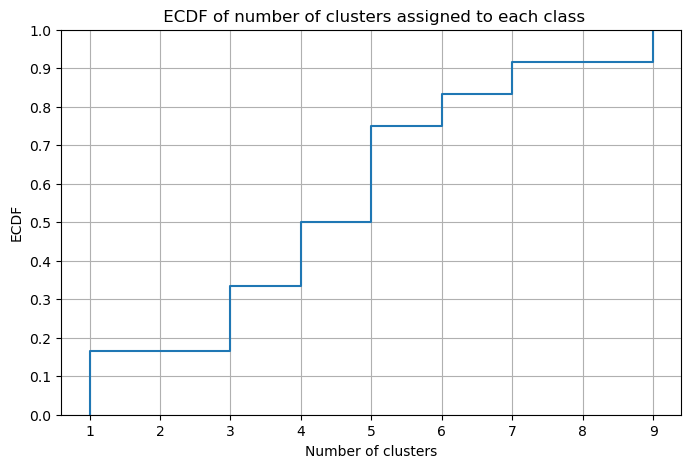

KeyError: 'label'

In [10]:
# sezione 4
plt.figure(figsize=(8, 5))
sns.ecdfplot(data=label_cluster_count_df, x='Unique_Clusters_Count')
plt.title(' ECDF of number of clusters assigned to each class')
plt.xlabel('Number of clusters')
plt.ylabel('ECDF')
plt.yticks(np.arange(0, 1.1, 0.1))  # This sets y-ticks at intervals of 0.1
plt.grid(True)
plt.show()


# Group by cluster label
grouped_by_cluster = label_cluster_count_df.groupby('Unique_Clusters_Count')

# Initialize a dictionary to hold the purity status of each cluster
cluster_purity = {}

# Check each cluster
for cluster_label, group in grouped_by_cluster:
    unique_labels = group['Label'].unique()
    cluster_purity[cluster_label] = len(unique_labels) == 1

# Print the purity status of each cluster
for cluster_label, is_pure in cluster_purity.items():
    print(f"Cluster {cluster_label} is {'pure' if is_pure else 'not pure'}")

